In [18]:
import numpy as np
from scipy.linalg import eigh, eig
from scipy.sparse import diags
from scipy.sparse.linalg import eigs
import matplotlib.pyplot as plt
import time

In [19]:
def create_reflective_laplacian(n, m):
    N = n * m  # Total number of points in the grid
    M = np.zeros((N, N))  # Initialize matrix with zeros

    for i in range(N):
        # Default value for cells
        M[i, i] = -4
        
        # Calculate row and column in the grid
        row, col = divmod(i, m)

        # Set connections for adjacent cells, considering the grid layout
        if col != 0:  # Not on the left edge
            M[i, i - 1] = 1  # Left neighbor
        if col != (m - 1):  # Not on the right edge
            M[i, i + 1] = 1  # Right neighbor
        if row != 0:  # Not on the top edge
            M[i, i - m] = 1  # Top neighbor
        if row != (n - 1):  # Not on the bottom edge
            M[i, i + m] = 1  # Bottom neighbor

    return M

# Example usage
n, m = 4, 4  # Change these to create a different size grid
L = create_reflective_laplacian(n, m)
print(L)

[[-4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -4.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1. -4. 

In [20]:
def create_circular_laplacian(n, m, radius):
    # Total points
    N = n * m
    # Center of the circle, adjusted for the rectangular grid
    center = np.array([n / 2 - 0.5, m / 2 - 0.5])
    # Initialize the matrix
    M = np.zeros((N, N))

    # Identify points inside the circle
    inside_circle = []
    for i in range(n):
        for j in range(m):
            if (np.array([i, j]) - center).dot(np.array([i, j]) - center) <= radius**2:
                inside_circle.append(i * m + j)

    # Now build the Laplacian only for these points
    for idx in inside_circle:
        x, y = divmod(idx, m)
        M[idx, idx] = -4
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < n and 0 <= ny < m and nx * m + ny in inside_circle:
                M[idx, nx * m + ny] = 1

    # Filter out the unused rows and columns
    M = M[np.ix_(inside_circle, inside_circle)]

    return M

# Example usage
n, m = 5, 6  # Change these for a different size grid
radius = 2  # Adjust radius as needed
L_circle_corrected = create_circular_laplacian(n, m, radius)

# Check if the matrix is square
if L_circle_corrected.shape[0] == L_circle_corrected.shape[1]:
    print("The matrix is square.")
    try:
        vals_circle, vecs_circle = eigh(L_circle_corrected)
        # Continue with your analysis or plotting
    except ValueError as e:
        print("Error in eigenvalue computation:", e)
else:
    print("The matrix is not square, check the Laplacian construction.")


The matrix is square.


In [21]:
# Square grid (already done)
n, m = 20, 20 
L_square = create_reflective_laplacian(n, m)

# Rectangle grid
n, m = 10, 20  # Change these for a different size grid
L_rect = create_reflective_laplacian(n, m)

# Circular grid
n, m = 5, 6  # Change these for a different size grid
radius = 2  # Make sure L and n are defined
L_circle = create_circular_laplacian(n, m, radius)

In [28]:
def solve_eigenproblem(L_square):
    # Solve the eigenvalue problem
    eigenvalues, eigenvectors = eigh(L_square)

    # Convert eigenvalues to real numbers
    eigenvalues = np.real(eigenvalues)

    # Create the dictionary mapping eigenvalues to eigenvectors
    eigen_dict = {}
    for i, val in enumerate(eigenvalues):
        vec = eigenvectors[:, i]
        # Convert complex eigenvectors to real and make them lists for easy representation
        vec_list = np.real(np.abs(vec)).tolist()
        # Add to dictionary
        eigen_dict[val] = vec_list

    return eigen_dict

In [29]:
def plot_eigenvectors(eigen_dict, nrows=None, ncols=None, num_eigenvectors=5, target_eigenvalue=0):
    # Sort eigenvalues based on closeness to the target_eigenvalue, select the closest num_eigenvectors
    sorted_eigenvals = sorted(eigen_dict.keys(), key=lambda x: abs(x - target_eigenvalue))
    closest_eigenvals = sorted_eigenvals[:num_eigenvectors]

    # Set up the plot
    fig, axes = plt.subplots(1, num_eigenvectors, figsize=(5 * num_eigenvectors, 5))
    if num_eigenvectors == 1:
        axes = [axes]  # Ensure axes is iterable for a single subplot

    # Plot each of the closest eigenvectors as a heatmap
    for ax, eigenvalue in zip(axes, closest_eigenvals):
        eigenvector = eigen_dict[eigenvalue]
        # Reshape eigenvector to a rectangle or square array
        if nrows is not None and ncols is not None:
            matrix = np.reshape(eigenvector, (nrows, ncols))
        else:
            # Fallback to square shape if dimensions are not specified
            side_length = int(np.sqrt(len(eigenvector)))
            matrix = np.reshape(eigenvector, (side_length, side_length))
        
        # Plot the heatmap
        c = ax.imshow(matrix, cmap='viridis', aspect='auto')
        fig.colorbar(c, ax=ax)
        ax.set_title(f'Eigenvalue: {eigenvalue:.2e}')  # Using scientific notation for clarity

    plt.tight_layout()
    plt.show()


373


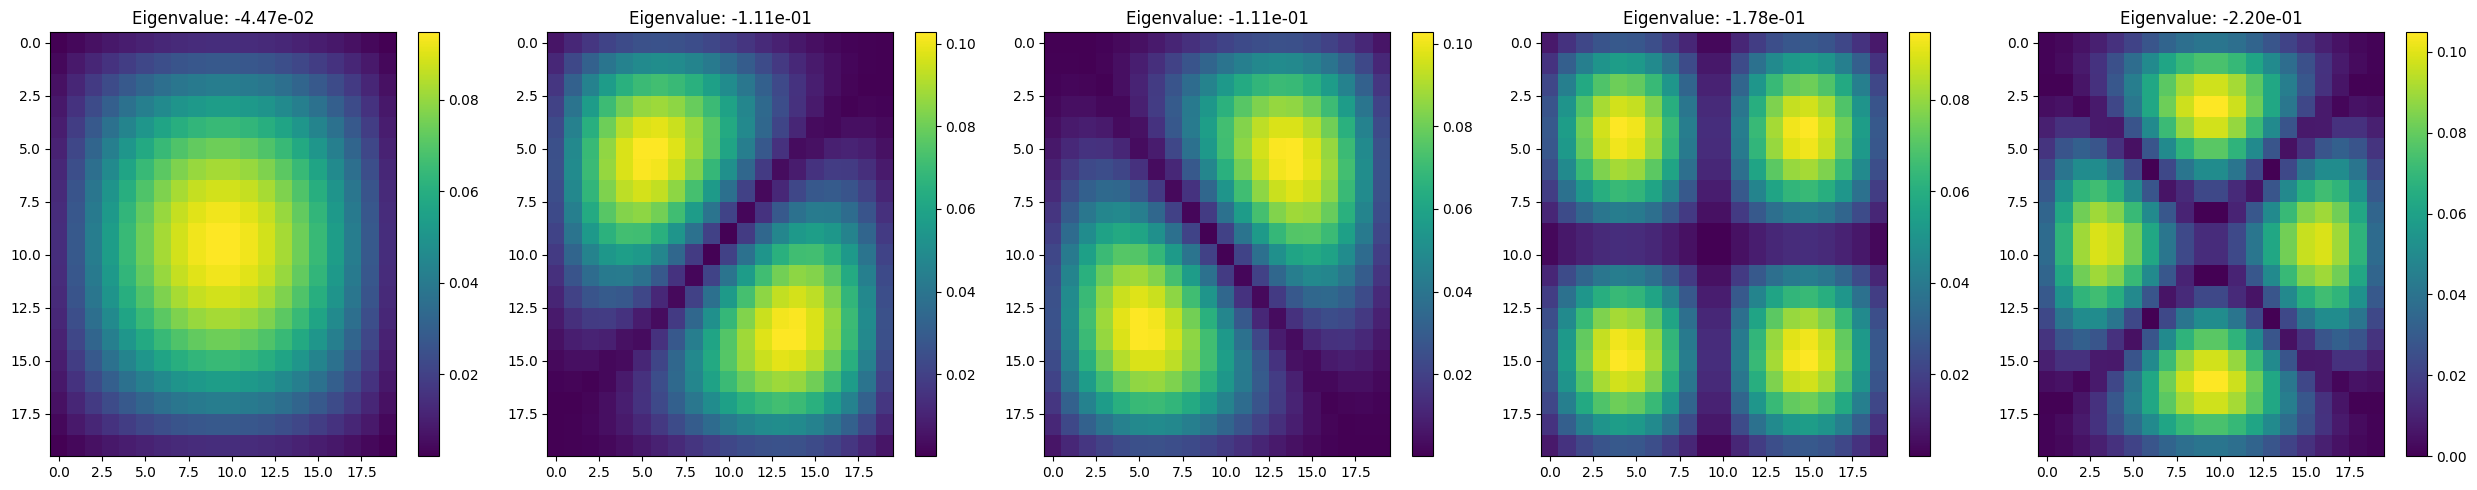

In [30]:
eigen_dict = solve_eigenproblem(L_square)
print(len(eigen_dict))
plot_eigenvectors(eigen_dict)

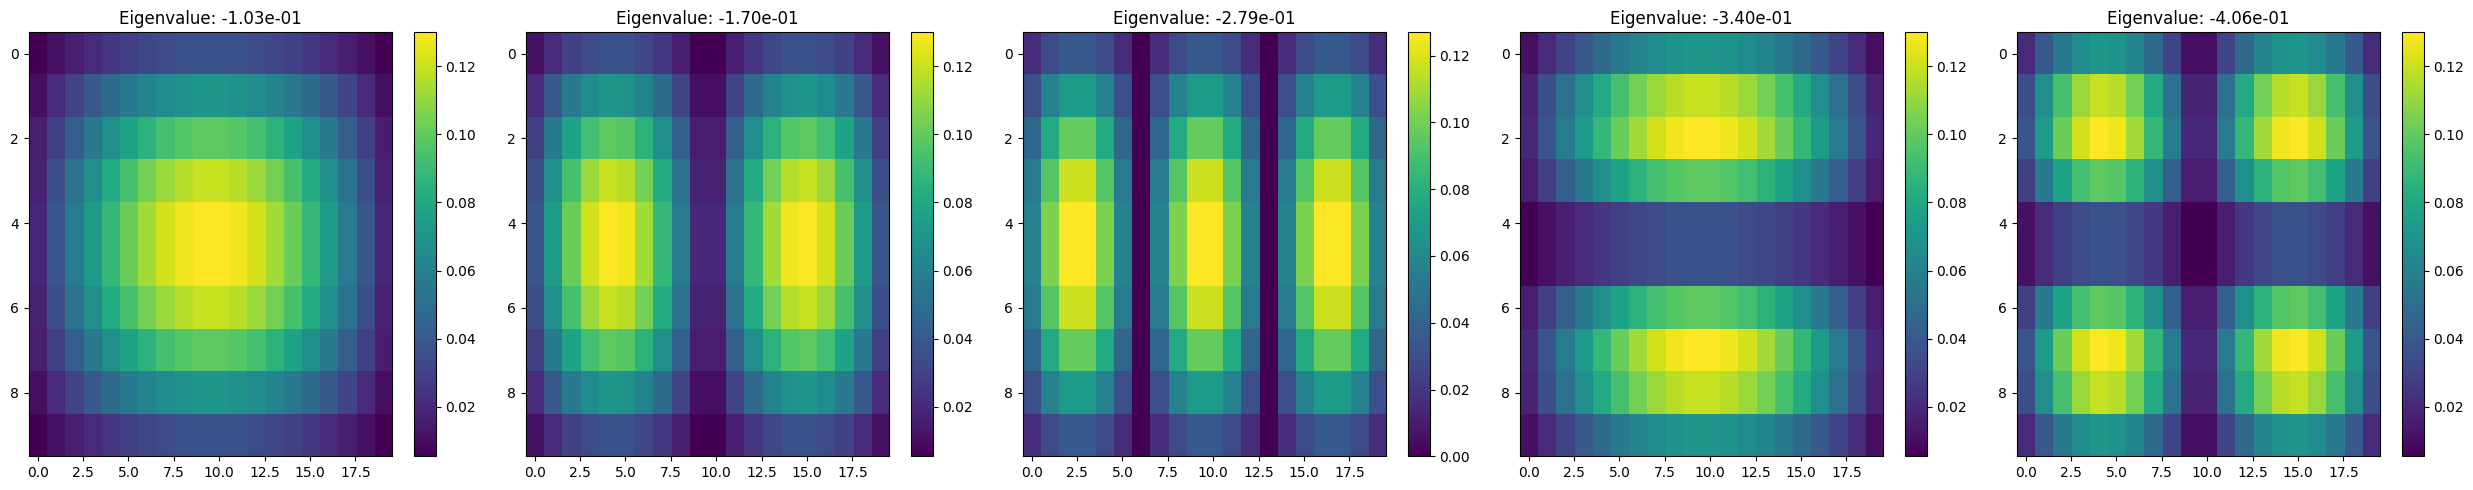

In [177]:
n, m = 10, 20  # Change these for a different size grid
eigen_dict = solve_eigenproblem(L_rect)
plot_eigenvectors(eigen_dict, nrows=n, ncols=m)

In [5]:
def embed_eigenvector_in_grid(eigenvector, n, m, inside_circle):
    """
    Embeds an eigenvector defined on the points inside a circle back into the full n x m grid.

    Parameters:
    eigenvector (numpy.ndarray): The flattened eigenvector defined only for points inside the circle.
    n (int): The number of rows in the full grid.
    m (int): The number of columns in the full grid.
    inside_circle (list): List of indices in the flattened full grid that correspond to points inside the circle.

    Returns:
    numpy.ndarray: The full n x m grid with the eigenvector embedded at the correct locations and zeros elsewhere.
    """
    # Create an empty array for the full grid
    full_grid = np.zeros(n * m)

    # Place the components of the eigenvector into the full grid at the appropriate locations
    for index, value in zip(inside_circle, eigenvector):
        full_grid[index] = value

    # Reshape the full grid back into a 2D array
    full_grid = full_grid.reshape((n, m))

    return full_grid


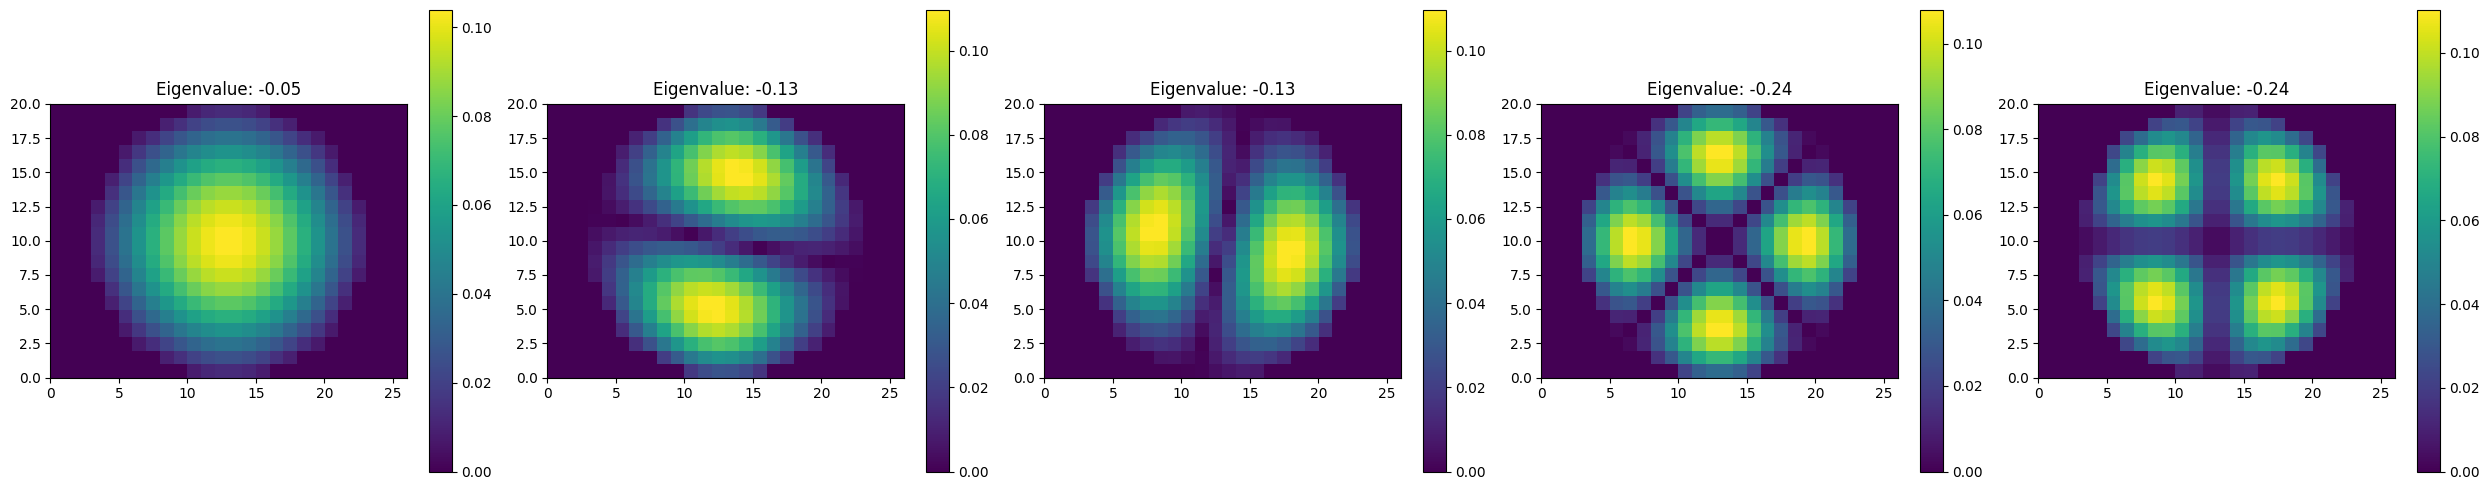

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

def plot_circular_eigenvectors(vals_circle, vecs_circle, n, m, radius, num_eigenvectors=5):
    # Calculate the positions inside the circle to properly embed eigenvectors later
    center = np.array([n / 2 - 0.5, m / 2 - 0.5])
    inside_circle = [i * m + j for i in range(n) for j in range(m) 
                     if np.linalg.norm(np.array([i, j]) - center) <= radius]

    # Sort eigenvalues and pick the indices of the closest to zero
    indices_closest = np.argsort(np.abs(vals_circle))[:num_eigenvectors]

    # Set up the plot
    fig, axes = plt.subplots(1, num_eigenvectors, figsize=(5 * num_eigenvectors, 5))
    if num_eigenvectors == 1:
        axes = [axes]  # Make sure axes is iterable

    # Plot the specified number of closest eigenvectors
    for i, idx in enumerate(indices_closest):
        # Embed the eigenvector back into the full grid
        full_grid = embed_eigenvector_in_grid(np.abs(vecs_circle[:, idx]), n, m, inside_circle)
        
        # Plot the heatmap
        c = axes[i].imshow(full_grid, cmap='viridis', extent=[0, m, 0, n], origin='lower')
        fig.colorbar(c, ax=axes[i])
        axes[i].set_title(f'Eigenvalue: {vals_circle[idx]:.2f}')
        axes[i].axis('on')

    plt.tight_layout()
    plt.show()

# Usage example
n, m = 20, 26  # Grid size
radius = 10  # Circle radius
L_circle_corrected = create_circular_laplacian(n, m, radius)
vals_circle, vecs_circle = eigh(L_circle_corrected)  # Compute eigenvalues and eigenvectors

plot_circular_eigenvectors(vals_circle, vecs_circle, n, m, radius)  # Adjust num_eigenvectors if needed


In the provided code, eigh() from scipy.linalg was used to solve the eigenvalue problem for the Laplacian matrix representing the reflective boundary conditions. The choice of eigh() over other options like eig() or eigs() was made because eigh() is specifically designed to efficiently solve Hermitian eigenvalue problems for symmetric matrices.

Since the Laplacian matrix representing the reflective boundary conditions is symmetric due to the nature of the problem, using eigh() is appropriate and efficient. This function is optimized for symmetric matrices, leading to faster computation times compared to other methods when dealing with such matrices. Therefore, eigh() was selected for its efficiency and suitability for the given problem.

In [179]:
# Example usage
n, m = 20, 20  # Change these for a different size grid
L = create_reflective_laplacian(n, m)

# Solve the eigenvalue problem using scipy.linalg.eig()
start_time = time.time()
eigenvalues_eig, eigenvectors_eig = eig(L)
end_time = time.time()
eig_time = end_time - start_time

# Solve the eigenvalue problem using scipy.linalg.eigh()
start_time = time.time()
eigenvalues_eigh, eigenvectors_eigh = eigh(L)
end_time = time.time()
eigh_time = end_time - start_time


# Solve the eigenvalue problem using scipy.sparse.linalg.eigs() for sparse matrices
start_time = time.time()
eigenvalues_eigs, eigenvectors_eigs = eigs(L)
end_time = time.time()
eigs_time = end_time - start_time

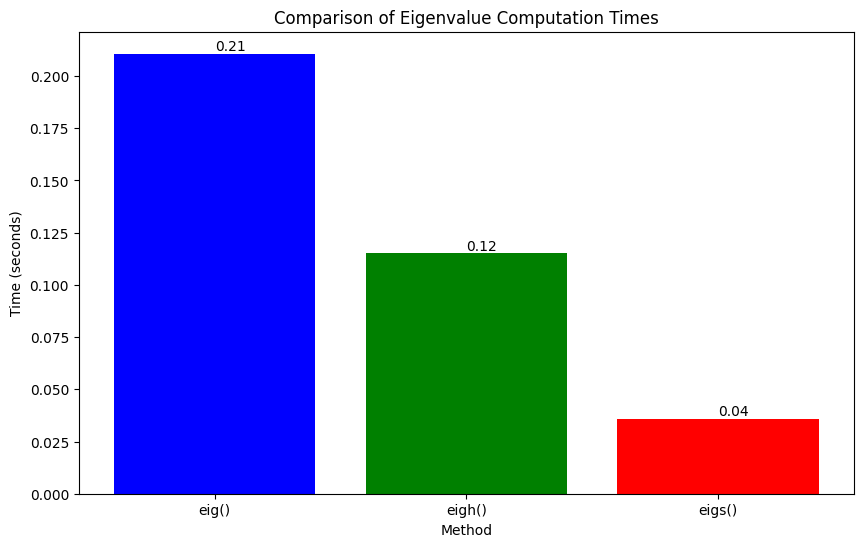

In [180]:
# Computation times from your results
method_names = ['eig()', 'eigh()', 'eigs()']
times = [eig_time, eigh_time, eigs_time]

# Create a bar chart
plt.figure(figsize=[10,6])
bars = plt.bar(method_names, times, color=['blue', 'green', 'red'])

# Add the exact computation time above each bar for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.2f}', va='bottom')  # Adjust the format as needed

# Set chart title and labels
plt.title('Comparison of Eigenvalue Computation Times')
plt.ylabel('Time (seconds)')
plt.xlabel('Method')

# Show the plot
plt.show()


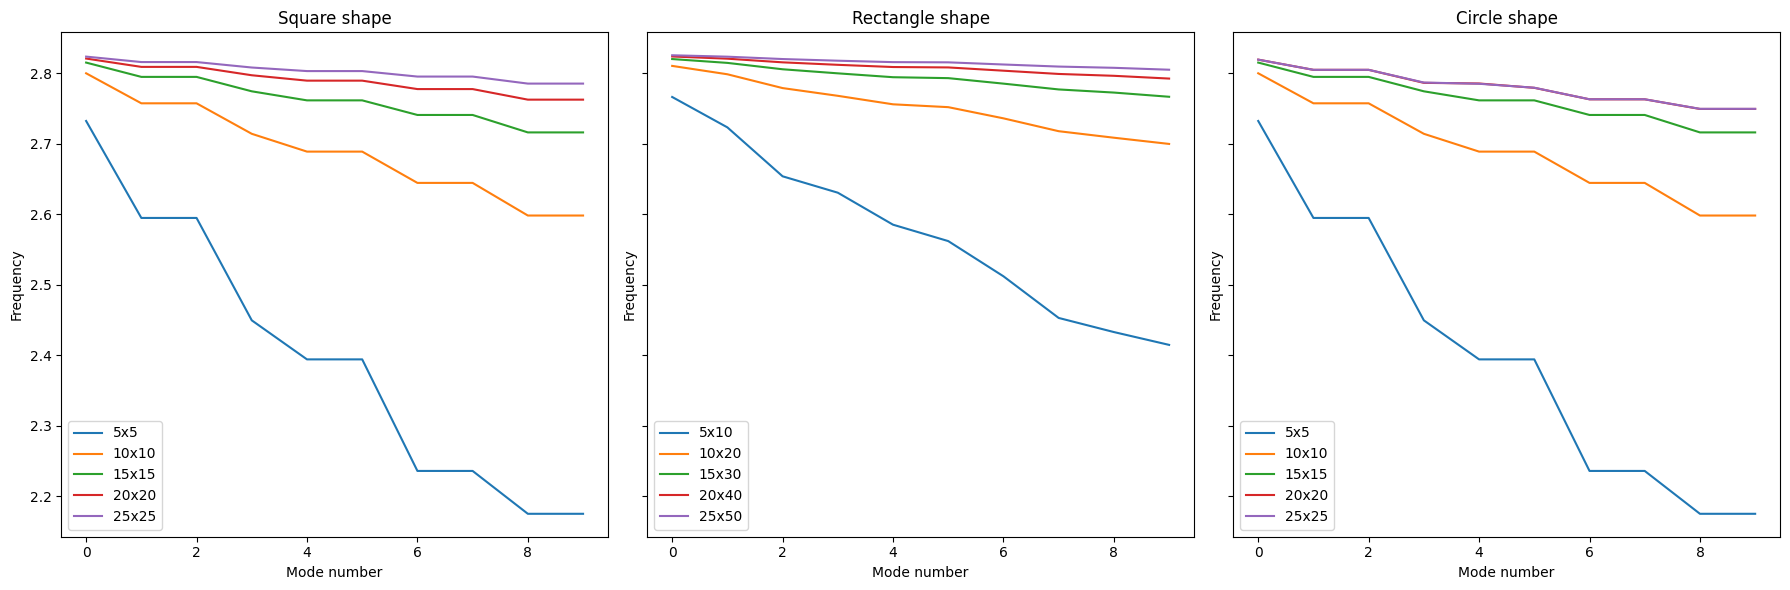

In [190]:
# Function to solve and return eigenvalues
def solve_eigenvalues(L):
    eigenvalues, _ = eigh(L)  # Only need eigenvalues, not eigenvectors
    return np.sqrt(np.abs(eigenvalues))  # Return the square root of eigenvalues for frequencies

# Define sizes and shapes for the analysis
sizes = range(5, 26, 5)  # From 5x5 to 25x25 with steps of 5
shapes = ['square', 'rectangle', 'circle']
radius = 10  # Fixed radius for circular shape
results = {shape: [] for shape in shapes}

# Calculate eigenfrequencies for each shape and size
for size in sizes:
    for shape in shapes:
        if shape == 'circle':
            L = create_circular_laplacian(size, size, radius=radius)
        else:
            L = create_reflective_laplacian(size, size if shape == 'square' else size * 2)  # Double the size for rectangle
        eigenvalues = solve_eigenvalues(L)
        results[shape].append(eigenvalues[:10])  # Store first 10 eigenfrequencies

# Plotting the results
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
for ax, shape in zip(axes, shapes):
    for size, freqs in zip(sizes, results[shape]):
        ax.plot(freqs, label=f'{size}x{size}' if shape != 'rectangle' else f'{size}x{size * 2}')
    ax.set_title(f'{shape.capitalize()} shape')
    ax.set_xlabel('Mode number')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

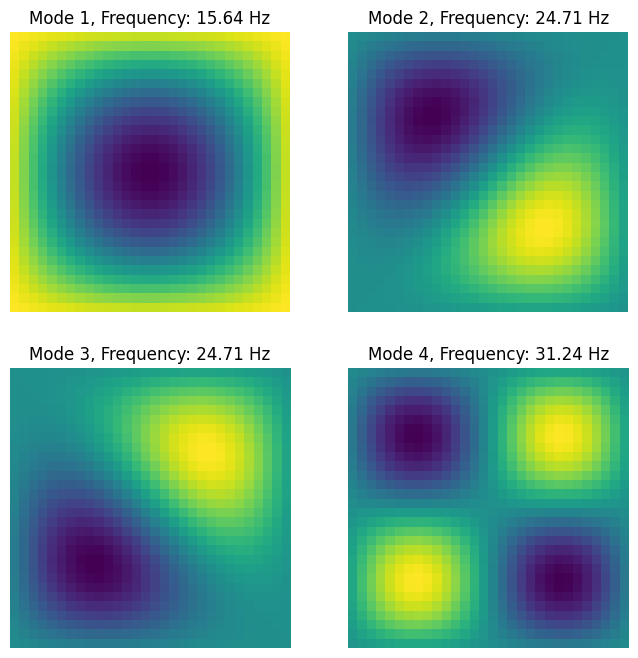

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter  # Import PillowWriter
import scipy.linalg as la

# Constants
L = 0.5  # Length of the side of the square, say half a meter for a small drum
N = 30  # Number of points in each dimension (excluding boundaries)
c = 343  # Speed of wave propagation in m/s (speed of sound in air for example)

# Solving the eigenvalue problem
laplacian = create_reflective_laplacian(N, N)
eigenvalues, eigenvectors = la.eigh(-laplacian)  # Negative sign for correct eigenvalues (Laplacian is negative definite)

# Convert eigenvalues to frequencies (lambda squared to lambda conversion)
frequencies = np.sqrt(np.abs(eigenvalues)) * c / (2 * np.pi * L)  # Adjusted for physical context

# Pick first few modes for animation
modes = eigenvectors[:, :4]  # Let's take the first 4 modes for illustration

# Prepare the animation
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

time_values = np.linspace(0, 2 * np.pi, 500)  # More frames for smoother animation

def animate(t):
    for i, ax in enumerate(axes.flatten()):
        mode_shape = modes[:, i].reshape((N, N))
        # Time-dependent part for smoother transition
        time_part = np.cos(c * frequencies[i] * t)
        ax.clear()
        ax.imshow(mode_shape * time_part, extent=[0, L, 0, L], origin='lower', cmap='viridis')
        ax.set_title(f'Mode {i+1}, Frequency: {frequencies[i]:.2f} Hz')
        ax.axis('off')

# Use more frames and possibly adjust interval for smoothness
ani = FuncAnimation(fig, animate, frames=np.linspace(0, 2 * np.pi, 300), interval=25)

# Save the animation as a GIF using Pillow
writer = PillowWriter(fps=10)  # Adjust fps as needed
ani.save('time_dependent_modes.gif', writer=writer)


# 2

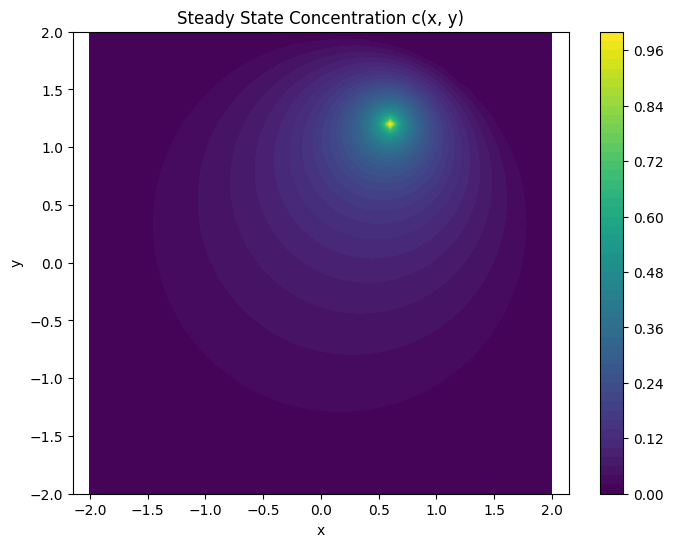

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve

# Parameters
radius = 2
source_point = (0.6, 1.2)
source_value = 1
grid_size = 0.05  # Distance between grid points
domain_points = int(2 * radius / grid_size) + 1  # Number of points in each dimension

# Function to check if a point is inside the circular domain
def inside_circle(x, y, center, radius):
    return (x - center[0])**2 + (y - center[1])**2 < radius**2

# Generate grid points
x = np.linspace(-radius, radius, domain_points)
y = np.linspace(-radius, radius, domain_points)
X, Y = np.meshgrid(x, y)

# Initialize matrices and vectors
M_data = []
M_row_indices = []
M_col_indices = []
b = np.zeros(domain_points**2)

# Populate the matrices and vectors
for i in range(domain_points):
    for j in range(domain_points):
        idx = i * domain_points + j  # Flatten the 2D grid index to a 1D index
        if inside_circle(X[i, j], Y[i, j], (0, 0), radius):
            if np.isclose(X[i, j], source_point[0]) and np.isclose(Y[i, j], source_point[1]):
                # Source point
                M_data.append(1)
                M_row_indices.append(idx)
                M_col_indices.append(idx)
                b[idx] = source_value
            else:
                # Internal point - Apply the finite difference method
                M_data.extend([1, -1/4, -1/4, -1/4, -1/4])
                M_row_indices.extend([idx, idx, idx, idx, idx])
                M_col_indices.extend([idx, idx - 1, idx + 1, idx - domain_points, idx + domain_points])
                b[idx] = 0
        else:
            # Boundary point
            M_data.append(1)
            M_row_indices.append(idx)
            M_col_indices.append(idx)
            b[idx] = 0

# Create the sparse matrix M
M = coo_matrix((M_data, (M_row_indices, M_col_indices)), shape=(domain_points**2, domain_points**2))

# Solve Mc = b
c = spsolve(M.tocsr(), b)

# Reshape c back into a 2D array
c = c.reshape((domain_points, domain_points))

# Plotting
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, c, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Steady State Concentration c(x, y)')
plt.axis('equal')
plt.show()


The matrix M and the vector b are constructed to represent the discretized version of the Laplace equation (∇²c = 0) for the diffusion problem within a circular domain, under certain boundary conditions. Here's a detailed breakdown of how this is done:

### 1. Grid Discretization:
We start by creating a grid of points that covers the circular domain with a certain grid size (spacing between points). This grid is used to approximate the continuous domain with discrete points where the solution will be computed.

### 2. Constructing the Matrix M:
The matrix M represents the discretized Laplacian operator (∇²) used in the diffusion equation, applied to each grid point. For interior points (not on the boundary), we use the five-point stencil method, which is a finite difference method for approximating the Laplacian. The idea here is to relate the value of the function at a point to the values at its immediate neighbors to approximate second derivatives.

For a grid point (i, j), this approximation is given by:
\[ \nabla^2 c \approx \frac{c_{i+1,j} + c_{i-1,j} + c_{i,j+1} + c_{i,j-1} - 4c_{i,j}}{(\text{grid size})^2} \]

In the matrix M, this corresponds to setting the central coefficient for point (i, j) to 1 (accounting for the -4 in the numerator when normalized by grid size squared) and the coefficients for the immediate neighbors to -1/4. For grid points near the edge but not on the boundary, if a neighbor falls outside the circle, that neighbor is ignored (effectively setting that term to zero).

### 3. Constructing the Vector b:
The vector b represents the boundary conditions and the source terms of the problem. For most grid points, this will be zero, reflecting the fact that there's no source there and the standard Laplace equation is ∇²c = 0. However, for points at the boundary of the domain, we set the corresponding value in b to 0, reflecting the Dirichlet boundary condition (c = 0 at the boundary).

For the source point (in this case at (0.6, 1.2)), we find the corresponding grid point and set its value in the vector b to the source concentration (1 in this case). This effectively enforces the condition that the concentration at this point remains fixed at 1.

### 4. Boundary Conditions:
The boundary conditions are taken into account in two ways:
- In the matrix M: For grid points that are on the boundary of the circular domain, we modify the corresponding row in the matrix to reflect that these points should not be affected by their neighbors (since they are outside the domain). This is done by setting the diagonal entry of M corresponding to a boundary point to 1 and all other entries in that row to 0.
- In the vector b: For these same boundary points, the corresponding entries in b are set to 0, respecting the condition c = 0 on the boundary. 

By solving the system Mc = b, we find the values of the concentration at all points in the grid, taking into account the effects of the source and the boundary conditions. This solution is then reshaped and plotted to visualize the steady-state concentration distribution.